<a href="https://colab.research.google.com/github/ellerywuyn/LEAR-lab/blob/3-stratification-and-percent-offensive/profanity_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install profanity-filter
from profanity_filter import ProfanityFilter
!python -m spacy download en
pf = ProfanityFilter()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 KB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00
  Created wheel for ordered-set: filename=ordered_set-3.1.1-py2.py3-none-any.whl size=7821 sha256=5dcfc787cd606cb254c588969eff801a911ba113fea07cb17814e853d29b6e80
  Stored in directory: /root/.cache/pip/wheels/0c/c1/59/fab3ebd141bf02663ee9773f16b18118ef7d51db

In [48]:
import re
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [18]:
tweets_df = pd.read_csv("/content/drive/MyDrive/labeled_data.csv")
tweets_df_interest = tweets_df[["class", "tweet"]]
tweets_df_interest = tweets_df_interest[tweets_df_interest["class"].isin([1,2])]
n_sample = sum(tweets_df_interest["class"] == 2)
class1 = tweets_df_interest["class"][tweets_df_interest["class"] == 1].sample(n_sample, random_state = 1).index
class2 = tweets_df_interest["class"][tweets_df_interest["class"] == 2].index
sampled_tweets_df = tweets_df_interest.loc[class1.union(class2)]
sampled_tweets_df["class"] = sampled_tweets_df["class"].replace(2, 0)

In [20]:
# use the model to get predictions and store them in a new column named "predictions" in sampled_tweets_df
sampled_tweets_df['num_bad_words'] = sampled_tweets_df.apply(lambda x: len(re.findall('\*{2,}', pf.censor(x["tweet"]))), axis=1)

In [23]:
sampled_tweets_df['num_total_words'] = sampled_tweets_df.apply(lambda x: len(x["tweet"].split()), axis=1)

In [24]:
sampled_tweets_df['prop_bad_words'] = sampled_tweets_df['num_bad_words'] / sampled_tweets_df['num_total_words']

In [26]:
# define a function to generate labels using the transformer model
def get_label_n(input):
  return 1 if pf.is_profane(input) else 0

In [27]:
# use the model to get predictions and store them in a new column named "predictions" in sampled_tweets_df
sampled_tweets_df['prediction'] = sampled_tweets_df.apply(lambda x: get_label_n(x["tweet"]), axis=1)

# change the "class" column to "label" for clarity purposes
sampled_tweets_df = sampled_tweets_df.rename(columns = {"class": "label"})

# reorder the columns
sampled_tweets_df = sampled_tweets_df.loc[:,['tweet', 'label', 'prediction', 'num_bad_words', 'num_total_words', 'prop_bad_words']]

In [28]:
sampled_tweets_df

,tweet,label,prediction,num_bad_words,num_total_words,prop_bad_words
0,!!! RT @mayasolovely: As a woman you shouldn't...,0,0,0,25,0.000000
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",1,1,2,19,0.105263
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",1,1,2,20,0.100000
7,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,1,1,1,13,0.076923
23,""" fuck no that bitch dont even suck dick "" &#1...",1,1,4,19,0.210526
...,...,...,...,...,...,...
24772,you might as well gone pussy pop on a stage,1,1,1,10,0.100000
24773,you niggers cheat on ya gf's? smh....,1,1,1,7,0.142857
24774,you really care bout dis bitch. my dick all in...,1,1,2,12,0.166667
24779,"you've gone and broke the wrong heart baby, an...",0,0,0,13,0.000000


In [30]:
num_bad_words_counts = sampled_tweets_df['num_bad_words'].value_counts()
num_bad_words_counts

0    4832
1    2291
2     868
3     247
4      60
5      19
6       7
7       2
Name: num_bad_words, dtype: int64

<Axes: ylabel='Frequency'>

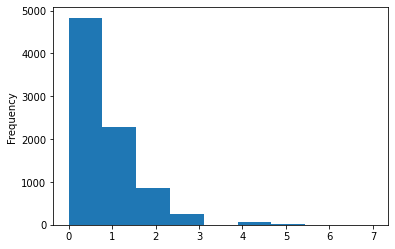

In [59]:
sampled_tweets_df['num_bad_words'].plot(kind='hist', bins=9)

<Axes: ylabel='Frequency'>

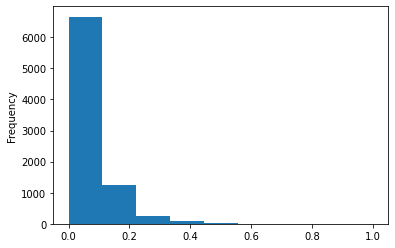

In [60]:
sampled_tweets_df['prop_bad_words'].plot(kind='hist', bins=9)

In [52]:
df_0_bad = sampled_tweets_df[sampled_tweets_df['num_bad_words'] == 0]
df_1_bad = sampled_tweets_df[sampled_tweets_df['num_bad_words'] == 1]
df_2_bad = sampled_tweets_df[sampled_tweets_df['num_bad_words'] == 2]
df_3_bad = sampled_tweets_df[sampled_tweets_df['num_bad_words'] == 3]
df_4_plus_bad = sampled_tweets_df[sampled_tweets_df['num_bad_words'] >= 4]

In [53]:
df_4_plus_bad

,tweet,label,prediction,num_bad_words,num_total_words,prop_bad_words
23,""" fuck no that bitch dont even suck dick "" &#1...",1,1,4,19,0.210526
135,"""@Gotti_LTF: Happy Bday Bitch Ass Nigga @JetsA...",1,1,4,11,0.363636
153,"""@JoeBudden: stop being scared to choke her du...",1,1,4,26,0.153846
339,"""@iDntWearCondoms: Watch women try to argue wi...",1,1,4,25,0.160000
686,#ChristianBale should be KISSING #Moses ass fo...,1,1,5,22,0.227273
...,...,...,...,...,...,...
21910,Thirsty fo da bitches saggin my pants n shit ....,1,1,4,23,0.173913
22045,This girl is the nastiest skank bitch I've eve...,1,1,4,20,0.200000
23349,You know i stay on fuck a bitch shit but with ...,1,1,4,20,0.200000
23369,You like where the hell is yo bitch meanwhile ...,1,1,4,19,0.210526


In [55]:
df_dict = {
    "0 bad words" : df_0_bad,
    "1 bad word" : df_1_bad,
    "2 bad words" : df_2_bad,
    "3 bad words" : df_3_bad,
    "4+ bad words" : df_4_plus_bad,
}

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

0 bad words 
                precision    recall  f1-score   support

not offensive       0.82      1.00      0.90      3974
    offensive       0.00      0.00      0.00       858

     accuracy                           0.82      4832
    macro avg       0.41      0.50      0.45      4832
 weighted avg       0.68      0.82      0.74      4832

     Metrics  Values
0   Accuracy    0.82
1  Precision    0.00
2     Recall    0.00
3         F1    0.00 



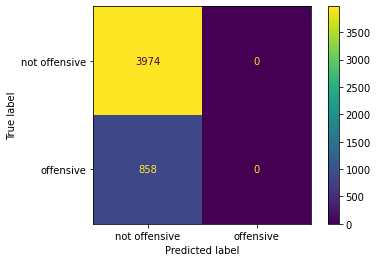

1 bad word 
                precision    recall  f1-score   support

not offensive       0.75      0.02      0.03       175
    offensive       0.92      1.00      0.96      2116

     accuracy                           0.92      2291
    macro avg       0.84      0.51      0.50      2291
 weighted avg       0.91      0.92      0.89      2291

     Metrics  Values
0   Accuracy    0.92
1  Precision    0.92
2     Recall    1.00
3         F1    0.96 



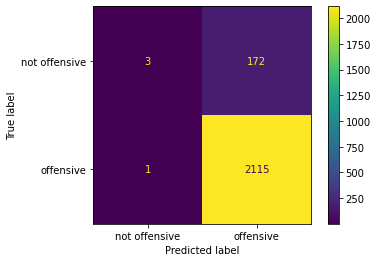

2 bad words 
                precision    recall  f1-score   support

not offensive       0.60      0.23      0.33        13
    offensive       0.99      1.00      0.99       855

     accuracy                           0.99       868
    macro avg       0.79      0.61      0.66       868
 weighted avg       0.98      0.99      0.98       868

     Metrics  Values
0   Accuracy    0.99
1  Precision    0.99
2     Recall    1.00
3         F1    0.99 



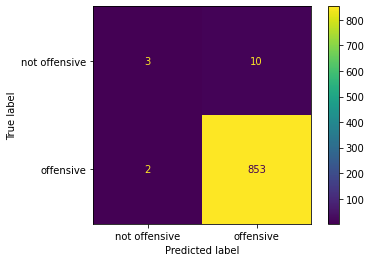

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3 bad words 
                precision    recall  f1-score   support

not offensive       0.00      0.00      0.00         1
    offensive       1.00      1.00      1.00       246

     accuracy                           1.00       247
    macro avg       0.50      0.50      0.50       247
 weighted avg       0.99      1.00      0.99       247

     Metrics  Values
0   Accuracy     1.0
1  Precision     1.0
2     Recall     1.0
3         F1     1.0 



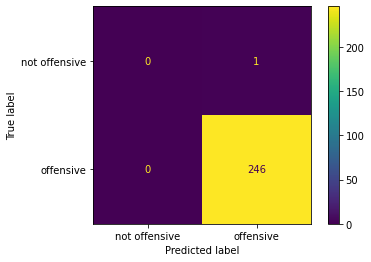

'4+ bad words' only has the offensive class


In [57]:
target_names = ["not offensive", "offensive"]
for key in df_dict:
  # print the classification reports for all 5
  try:
    print(key, "\n", classification_report(df_dict[key]["label"], df_dict[key]["prediction"], target_names=target_names))

    metrics = {
      "Metrics": ["Accuracy", "Precision", "Recall", "F1"],
      "Values": [round(np.average(accuracy_score(df_dict[key]["label"], df_dict[key]["prediction"])), 2), 
                round(np.average(precision_score(df_dict[key]["label"], df_dict[key]["prediction"])), 2), 
                round(np.average(recall_score(df_dict[key]["label"], df_dict[key]["prediction"])), 2), 
                round(np.average(f1_score(df_dict[key]["label"], df_dict[key]["prediction"])), 2)]
    }
    print(pd.DataFrame(metrics), "\n")
    cm = confusion_matrix(df_dict[key]["label"], df_dict[key]["prediction"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot()
    plt.show()
  except ValueError:
    print("'4+ bad words' only has the offensive class")


### Misclassifications

In [65]:
df_0_bad[(df_0_bad["prediction"] == 0) & (df_0_bad["label"] == 1)]

,tweet,label,prediction,num_bad_words,num_total_words,prop_bad_words
39,""" like Snoop said in 94 we dont love these hoes """,1,0,0,12,0.0
104,"""@ComedyTruth: amen miley &#128591; http://t.c...",1,0,0,20,0.0
208,"""@PRETTyBOSs_BRAt: We don't love these hoes &#...",1,0,0,7,0.0
236,"""@Shun_stokes: My cousin said he share hoes wi...",1,0,0,21,0.0
237,"""@SlimGirl_Probz: i'm hungry but ionn wanna sp...",1,0,0,14,0.0
...,...,...,...,...,...,...
24696,why even get pregnant by someone that isn't an...,1,0,0,21,0.0
24739,yeah I'm small den a hoe http://t.co/VV3qdTo7MG,1,0,0,7,0.0
24740,yeah i got soul i was brought up by colored wo...,1,0,0,11,0.0
24754,"you are a hoe, hoe, &amp; a hoe.",1,0,0,8,0.0


In [63]:
df_1_bad[df_1_bad["prediction"] == 0]["tweet"]

321      "@complex_uk: Ashley Young has tried to deny t...
9620     Haha a private industry birthday is needed to ...
12297    Laat Zihni Ozdil met rust jullie gemene trolle...
19817    RT @pambesteder: **WOW* according to this twee...
Name: tweet, dtype: object

In [ ]:
  accuracy_score(df_dict[key]["label"], df_dict[key]["prediction"])
  precision_score(df_dict[key]["label"], df_dict[key]["prediction"])
  recall_score(df_dict[key]["label"], df_dict[key]["prediction"])
  f1_score(df_dict[key]["label"], df_dict[key]["prediction"])

In [15]:
censored = pf.censor("that's bullshit!")

len(re.findall('\*{2,}', censored))
len(re.findall('\*{2,}', pf.censor(x["tweet"])))

3

In [9]:
matches

['**', '**', '**', '**']

In [7]:
censored

"That's ********!"